In [1]:
import os
import requests
import json
import pandas as pd
import numpy as np

# Importing libraries for data visualization
import matplotlib.pylab as plt

# Importing an advanced library for data visualization
import seaborn as sns

# Importing library for date manipulation
from datetime import datetime

# To calculate the MSE or RMSE
from sklearn.metrics import mean_squared_error

# Importing acf and pacf functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Importing models from statsmodels library
from statsmodels.tsa.ar_model import AutoReg

from statsmodels.tsa.arima.model import ARIMA

In [2]:
url = 'https://www.alphavantage.co/query?function=FX_DAILY&outputsize=full&from_symbol=INR&to_symbol=USD&apikey=4B1MJYHIH3MK5EEC'
r = requests.get(url)
data = r.json()
#print(type(data))
#print(data.keys())
#print(data['Time Series FX (Daily)'].keys())
#print(data['Time Series FX (Daily)'])
#print(data['Time Series FX (Daily)']['2022-10-10'])

df = pd.DataFrame.from_dict(data['Time Series FX (Daily)'], orient ='index')
df.index.name='Date'
df = df.set_index(pd.to_datetime(df.index))
df.rename(columns = {'1. open':'Open', '2. high':'High', '3. low':'Low', '4. close':'Close'}, inplace = True)
df['Open'] = df['Open'].astype(float, errors = 'raise')
df['High'] = df['High'].astype(float, errors = 'raise')
df['Low'] = df['Low'].astype(float, errors = 'raise')
df['Close'] = df['Close'].astype(float, errors = 'raise')
print(df)
df.info()
df.tail()

#forex_data = json.loads(str(data))

#print('Forex Data\n'+str(forex_data))

               Open     High      Low    Close
Date                                          
2022-10-21  0.01208  0.01211  0.01205  0.01211
2022-10-20  0.01204  0.01211  0.01200  0.01208
2022-10-19  0.01215  0.01215  0.01203  0.01204
2022-10-18  0.01216  0.01218  0.01213  0.01215
2022-10-17  0.01214  0.01217  0.01213  0.01216
...             ...      ...      ...      ...
2014-11-13  0.01628  0.01629  0.01623  0.01624
2014-11-12  0.01625  0.01629  0.01623  0.01629
2014-11-11  0.01624  0.01626  0.01624  0.01624
2014-11-10  0.01628  0.01629  0.01622  0.01624
2014-11-07  0.01622  0.01629  0.01622  0.01628

[2075 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075 entries, 2022-10-21 to 2014-11-07
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2075 non-null   float64
 1   High    2075 non-null   float64
 2   Low     2075 non-null   float64
 3   Close   2075 non-null   float64
dtypes: float64(4)

,Open,High,Low,Close
Date,,,,
2014-11-13,0.01628,0.01629,0.01623,0.01624
2014-11-12,0.01625,0.01629,0.01623,0.01629
2014-11-11,0.01624,0.01626,0.01624,0.01624
2014-11-10,0.01628,0.01629,0.01622,0.01624
2014-11-07,0.01622,0.01629,0.01622,0.01628


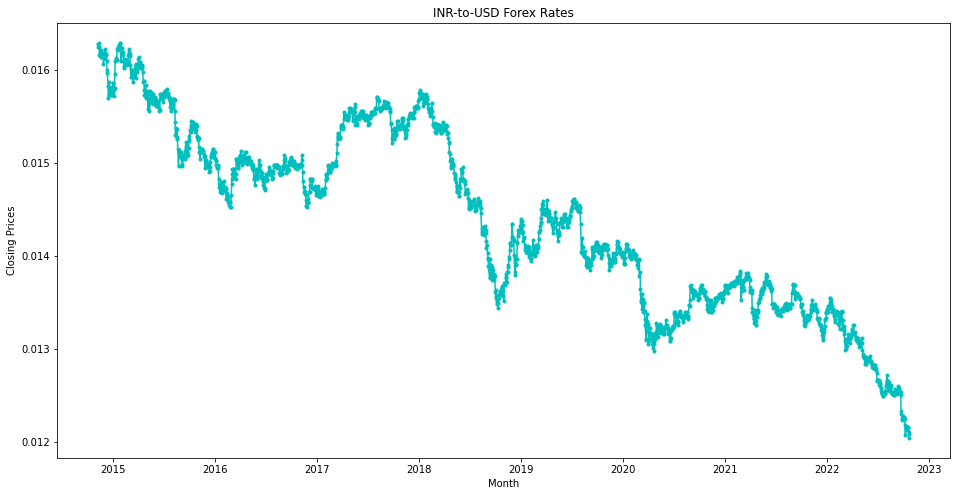

In [3]:
# Visualizing the time series
plt.figure(figsize=(16, 8))
plt.xlabel("Month")
plt.ylabel("Closing Prices")
plt.title('INR-to-USD Forex Rates')
plt.plot(df.index, df.Close, color = 'c', marker = '.')
#plt.plot(df.index, df.High, color = 'r', marker = '.')

In [4]:
#Use the Close Stock Price Column to Train the Model.
training_set = df.iloc[:,3:4].values
print(training_set)
print(training_set.shape)
print("Number of rows in training set is: "+str(len(training_set)))

[[0.01211]
 [0.01208]
 [0.01204]
 ...
 [0.01624]
 [0.01624]
 [0.01628]]
(2075, 1)
Number of rows in training set is: 2075


In [5]:
#Check data quality
print(df.isna().values.any())
print("Number of missing values in each column of the dataframe:\n"+str(df.isnull().sum())+"\n")

False
Number of missing values in each column of the dataframe:
Open     0
High     0
Low      0
Close    0
dtype: int64



In [6]:
#Normalize the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
scaled_training_set = scaler.fit_transform(training_set)
scaled_training_set

array([[0.01647059],
       [0.00941176],
       [0.        ],
       ...,
       [0.98823529],
       [0.98823529],
       [0.99764706]])

In [7]:
#Creating X_train and y_train Data Structures
x_train = []
y_train = []

#what is 60 here?
for i in range(60,len(training_set)):
    x_train.append(scaled_training_set[i-60:i,0])
    y_train.append(scaled_training_set[i,0])
x_train = np.array(x_train)
y_train = np.array(y_train)

print(x_train.shape)
print(y_train.shape)

(2015, 60)
(2015,)


In [8]:
#Reshape data - why is this required?
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1))
x_train.shape

(2015, 60, 1)

In [9]:
#Building the LSTM Model
#Anaconda Navigator -> Enviroments -> Play button -> Open Terminal -> conda install keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences=True, input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

Using TensorFlow backend.
2022-10-22 19:03:29.717023: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-22 19:03:29.717329: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [10]:
import sys
print(sys.version)

3.7.13 (default, Mar 28 2022, 07:24:34) 
[Clang 12.0.0 ]


In [11]:
#Fitting the model
regressor.compile(optimizer='adam', loss='mean_squared_error')
regressor.fit(x_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
2015/2015 [==============================] - 40s 20ms/step - loss: 0.0299
Epoch 2/100
2015/2015 [==============================] - 31s 16ms/step - loss: 0.0053
Epoch 3/100
2015/2015 [==============================] - 31s 15ms/step - loss: 0.0052
Epoch 4/100
2015/2015 [==============================] - 32s 16ms/step - loss: 0.0049
Epoch 5/100
2015/2015 [==============================] - 31s 15ms/step - loss: 0.0046
Epoch 6/100
2015/2015 [==============================] - 31s 16ms/step - loss: 0.0041
Epoch 7/100
2015/2015 [==============================] - 31s 16ms/step - loss: 0.0040
Epoch 8/100
2015/2015 [==============================] - 33s 16ms/step - loss: 0.0038
Epoch 9/100
2015/2015 [==============================] - 45s 22ms/step - loss: 0.0037
Epoch 10/100
2015/2015 [==============================] - 37s 18ms/step - loss: 0.0035
Epoch 11/100
2015/2015 [==============================] - 33s 17ms/step - loss: 0.0034
Epoch 12/100
2015/2015 [============================

2015/2015 [==============================] - 33s 17ms/step - loss: 7.6080e-04
Epoch 95/100
2015/2015 [==============================] - 37s 18ms/step - loss: 7.5520e-04
Epoch 96/100
2015/2015 [==============================] - 33s 16ms/step - loss: 7.6279e-04
Epoch 97/100
2015/2015 [==============================] - 34s 17ms/step - loss: 7.9462e-04
Epoch 98/100
2015/2015 [==============================] - 33s 16ms/step - loss: 7.9716e-04
Epoch 99/100
2015/2015 [==============================] - 35s 17ms/step - loss: 7.8961e-04
Epoch 100/100
2015/2015 [==============================] - 33s 17ms/step - loss: 7.9272e-04


In [27]:
#9. Extracting the Actual Forex Rates of Oct-22, 2022
url_test = 'https://www.alphavantage.co/query?function=FX_DAILY&outputsize=full&from_symbol=INR&to_symbol=USD&apikey=4B1MJYHIH3MK5EEC'
r_test = requests.get(url_test)
data_test = r_test.json()
df_test = pd.DataFrame.from_dict(data_test['Time Series FX (Daily)'], orient ='index')
df_test.index.name='Date'
df_test = df_test.set_index(pd.to_datetime(df_test.index))
df_test.rename(columns = {'1. open':'Open', '2. high':'High', '3. low':'Low', '4. close':'Close'}, inplace = True)
df_test['Open'] = df_test['Open'].astype(float, errors = 'raise')
df_test['High'] = df_test['High'].astype(float, errors = 'raise')
df_test['Low'] = df_test['Low'].astype(float, errors = 'raise')
df_test['Close'] = df_test['Close'].astype(float, errors = 'raise')
print(df_test)
df_test.info()
df_test.tail()

               Open     High      Low    Close
Date                                          
2022-10-21  0.01207  0.01211  0.01205  0.01210
2022-10-20  0.01204  0.01211  0.01200  0.01208
2022-10-19  0.01215  0.01215  0.01203  0.01204
2022-10-18  0.01216  0.01218  0.01213  0.01215
2022-10-17  0.01214  0.01217  0.01213  0.01216
...             ...      ...      ...      ...
2014-11-13  0.01628  0.01629  0.01623  0.01624
2014-11-12  0.01625  0.01629  0.01623  0.01629
2014-11-11  0.01624  0.01626  0.01624  0.01624
2014-11-10  0.01628  0.01629  0.01622  0.01624
2014-11-07  0.01622  0.01629  0.01622  0.01628

[2075 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075 entries, 2022-10-21 to 2014-11-07
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2075 non-null   float64
 1   High    2075 non-null   float64
 2   Low     2075 non-null   float64
 3   Close   2075 non-null   float64
dtypes: float64(4)

,Open,High,Low,Close
Date,,,,
2014-11-13,0.01628,0.01629,0.01623,0.01624
2014-11-12,0.01625,0.01629,0.01623,0.01629
2014-11-11,0.01624,0.01626,0.01624,0.01624
2014-11-10,0.01628,0.01629,0.01622,0.01624
2014-11-07,0.01622,0.01629,0.01622,0.01628


In [34]:
#Use the Close Stock Price Column to Train the Model.
actual_forex_rate = df_test.iloc[:,3:4].values
print(actual_forex_rate)
print(actual_forex_rate.shape)
print("Number of rows in testing set is: "+str(len(actual_forex_rate)))

[[0.0121 ]
 [0.01208]
 [0.01204]
 ...
 [0.01624]
 [0.01624]
 [0.01628]]
(2075, 1)
Number of rows in testing set is: 2075


In [37]:
#Preparing the Input for the Model.
dataset_total = pd.concat((df['Open'], df_test['Open']), axis=0)
inputs = dataset_total[len(dataset_total) - len(df_test)-60:].values
print("inputs before scaler transform: "+str(inputs))

inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
print("inputs after scaler transform: "+str(inputs))

x_test = []
for i in range(60,len(actual_forex_rate)):
    x_test.append(inputs[i-60:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], 1))
x_test


inputs before scaler transform: [0.01618 0.01629 0.01629 ... 0.01624 0.01628 0.01622]
inputs after scaler transform: [[0.97411765]
 [1.        ]
 [1.        ]
 ...
 [0.98823529]
 [0.99764706]
 [0.98352941]]


array([[[0.97411765],
        [1.        ],
        [1.        ],
        ...,
        [0.98823529],
        [0.99764706],
        [0.98352941]],

       [[1.        ],
        [1.        ],
        [0.99294118],
        ...,
        [0.99764706],
        [0.98352941],
        [0.00705882]],

       [[1.        ],
        [0.99294118],
        [0.99529412],
        ...,
        [0.98352941],
        [0.00705882],
        [0.        ]],

       ...,

       [[0.89176471],
        [0.86823529],
        [0.86823529],
        ...,
        [0.96235294],
        [0.97647059],
        [0.97176471]],

       [[0.86823529],
        [0.86823529],
        [0.88470588],
        ...,
        [0.97647059],
        [0.97176471],
        [0.98588235]],

       [[0.86823529],
        [0.88470588],
        [0.90352941],
        ...,
        [0.97176471],
        [0.98588235],
        [0.97647059]]])

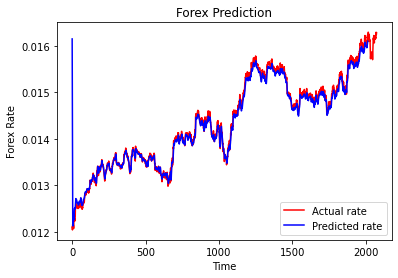

In [38]:
#Predicting the Values for Oct/Nov rates

predicted_forex_rate = regressor.predict(x_test)
predicted_forex_rate = scaler.inverse_transform(predicted_forex_rate)

plt.plot(actual_forex_rate, color = 'red', label = 'Actual rate')
plt.plot(predicted_forex_rate, color = 'blue', label = 'Predicted rate')
plt.title('Forex Prediction')
plt.xlabel('Time')
plt.ylabel('Forex Rate')
plt.legend()